# **Stock Market Analysis with Python - an ETL Pipeline**

In this python notebook, we are going to create a full [ETL (Extract, Transform, Load)](https://www.snowflake.com/guides/etl-pipeline/) data pipeline. We will do some data enrichment, data analysis and visualisation, and find some insights about the stocks we are looking at.

I wrote this notebook in [Google Colab](https://colab.research.google.com/), so I recommend running it there for the easiest experience, but this notebook should run in your local environment or anywhere else with a couple of minor modifications.


####**Extract**
Our first step will be to connect to the Alpha Vantage API to get historical stock market data. You will need to sign up to get your own API key for this service for this to work for you.

####**Transform**
Then we will use [pandas](https://pandas.pydata.org/) to perform some data transformation and enrichment, based on the data we pulled from the API.

####**Load**
Our next step will be to load the transformed data into a [Clickhouse Cloud instance](https://clickhouse.cloud). I used the free trial for Clickhouse to get familiar with it, and you can too.

####Analyse
Then we will work with [Vega-Altair](https://altair-viz.github.io/index.html) to make some nice visualisations and draw some conclusions about the three stocks we're looking at.

#### Let's get into it

### Step 1 - Data Extraction
**bold text**

### Step 1a - **Defining Functions: Connecting to the Alpha Vantage API, extracting our data**
We're going to look at three well-known stocks: Apple (AAPL), Microsoft (MSFT) and Google (GOOGL). You can of course modify this code to look at more or fewer and different stocks.


In [39]:
import requests
import pandas as pd
import numpy as np
from google.colab import userdata

# Retrieve the Alpha Vantage API key from Colab's secure storage
api_key = INSERT_YOUR_API_KEY_HERE


# Define a function to connect to the Alpha Vantage API and extract the relevant data
def get_weekly_data(symbol):
    """
    Retrieve weekly time series for a given stock symbol.
    """
    base_url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_WEEKLY"

    params = {
        "function": function,
        "symbol": symbol,
        "apikey": api_key
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()

        if "Error Message" in data:
            print(f"API Error: {data['Error Message']}")
            return None

        if "Note" in data:
            print(f"API Note: {data['Note']}")
            return None

        if "Weekly Time Series" not in data:
            print("Error: 'Weekly Time Series' not found in the API response")
            print("API Response:", data)
            return None

        df = pd.DataFrame.from_dict(data["Weekly Time Series"], orient="index")
        df.index = pd.to_datetime(df.index)
        df = df.astype(float)

        # Rename columns for clarity
        df.columns = ['open', 'high', 'low', 'close', 'volume']

        return df

    except requests.exceptions.RequestException as e:
        print(f"Request Error: {e}")
        return None
    except ValueError as e:
        print(f"JSON Decoding Error: {e}")
        return None
    except Exception as e:
        print(f"Unexpected Error: {e}")
        return None




### Step 1b - **Defining Functions: Enriching and transforming the extracted data**
Now we define a function to take the extracted data and enrich it, by calculating a number of useful financial / investment metrics.

In [40]:
def enrich_stock_data(df):
    """
    Add additional metrics and ratios to the stock DataFrame.
    """
    # 1. Market traded volume in USD
    df['volume_usd'] = df['close'] * df['volume']

    # 2. Weekly returns
    df['weekly_return'] = df['close'].pct_change()

    # 3. 4-week rolling average of closing price
    df['ma_4w'] = df['close'].rolling(window=4).mean()

    # 4. 8-week rolling average of closing price (changed from 12-week)
    df['ma_8w'] = df['close'].rolling(window=8).mean()

    # 5. Bollinger Bands (10-week, 2 standard deviations)
    df['bb_middle'] = df['close'].rolling(window=10).mean()
    bb_std = df['close'].rolling(window=10).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)

    # 6. Relative Strength Index (RSI) - 10-week
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=10).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=10).mean()
    rs = gain / loss
    df['rsi_10w'] = 100 - (100 / (1 + rs))

    # 7. Weekly volatility (standard deviation of returns)
    df['volatility'] = df['weekly_return'].rolling(window=8).std() * np.sqrt(52)

    return df


def compare_stocks(symbols, start_date=None, end_date=None):
    """
    Compare weekly data for multiple stock symbols and enrich with additional metrics.
    """
    results = {}
    for symbol in symbols:
        df = get_weekly_data(symbol)
        if df is not None:
            df = enrich_stock_data(df)
            if start_date:
                df = df[df.index >= start_date]
            if end_date:
                df = df[df.index <= end_date]
            results[symbol] = df
        else:
            print(f"Failed to retrieve data for {symbol}")

    return results

def display_recent_data(df, rows=5):
    """
    Display the most recent rows of data, excluding rows with NaN values.
    """
    # Reverse the DataFrame to start from the most recent data
    df_reversed = df.iloc[::-1]

    # Find the first row without NaN values
    first_full_row = df_reversed.dropna().index[0]

    # Display the specified number of rows from the first full row
    return df_reversed.loc[first_full_row:].head(rows)


### Step 1c - **Use the functions and extract the data**
In this step we identify our stock symbols of interest and use the functions we defined before to pull the data we're interested in - in this case weekly data for the whole year of 2023.'

In [41]:
# Example usage
symbols = ["AAPL", "MSFT", "GOOGL"]  # Apple, Microsoft, Google
start_date = "2023-01-01"
end_date = "2024-01-01"

stock_data = compare_stocks(symbols, start_date, end_date)

for symbol, df in stock_data.items():
    print(f"\n{symbol}:")
    print(display_recent_data(df))
    print(f"Shape of the DataFrame: {df.shape}")

# Print API key (first 5 characters) for debugging
if api_key:
    print(f"\nAPI Key (first 5 chars): {api_key[:5]}...")
else:
    print("\nAPI Key not found. Make sure you've added it to Colab's secure storage.")


AAPL:
               open    high     low   close       volume    volume_usd  \
2023-01-06  130.280  130.90  124.17  129.62  369948527.0  4.795273e+10   
2023-01-13  130.465  134.92  128.12  134.76  333335284.0  4.492026e+10   
2023-01-20  134.830  138.61  133.77  137.87  271823466.0  3.747630e+10   
2023-01-27  138.120  147.23  137.90  145.93  338655715.0  4.942003e+10   
2023-02-03  144.955  157.38  141.32  154.50  480249683.0  7.419858e+10   

            weekly_return     ma_4w      ma_8w  bb_middle    bb_upper  \
2023-01-06      -0.038142  137.0450  144.11875    145.248  161.946588   
2023-01-13      -0.022557  143.2650  146.79500    147.786  161.348187   
2023-01-20      -0.055232  147.3275  148.51250    150.335  162.528799   
2023-01-27      -0.055469  150.9975  150.65375    153.038  164.931052   
2023-02-03       0.023111  151.1925  152.44375    154.911  167.694957   

              bb_lower    rsi_10w  volatility  
2023-01-06  128.549412  24.154786    0.250127  
2023-01-13  1

### Step 2 - **Load the transformed data into [Clickhouse](https://clickhouse.cloud)**
Now we connect to our database in Clickhouse. To do this we need to first install [clickhouse-connect](https://clickhouse.com/docs/en/integrations/python), the python package for connecting to Clickhouse.

Once that's done we'll create a couple of functions to create tables at Clickhouse and insert the data from our dataframes. Then it's a case of defining our configuration and running the functions.

### Step 2a - **Install Clickhouse Connect.**


In [9]:
!pip install clickhouse-connect

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.9/977.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 44.3 MB/s eta 0:00:00


### Step 2b - **Define the functions to connect to Clickhouse, create and populate our tables**

In [42]:
import clickhouse_connect
import pandas as pd
from datetime import datetime

def connect_to_clickhouse(host, port, user, password, database):
    """
    Establish a secure connection to ClickHouse using clickhouse-connect.
    """
    client = clickhouse_connect.get_client(
        host=host,
        port=port,
        username=user,
        password=password,
        database=database,
        secure=True
    )
    return client

def create_table_if_not_exists(client, table_name):
    """
    Create a table in ClickHouse if it doesn't already exist.
    """
    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        date Date,
        symbol String,
        open Float64,
        high Float64,
        low Float64,
        close Float64,
        volume Int64,
        volume_usd Float64,
        weekly_return Float64,
        ma_4w Float64,
        ma_8w Float64,
        bb_middle Float64,
        bb_upper Float64,
        bb_lower Float64,
        rsi_10w Float64,
        volatility Float64
    ) ENGINE = MergeTree()
    ORDER BY (date, symbol)
    """
    client.command(create_table_query)

def insert_data_to_clickhouse(client, table_name, df):
    """
    Insert data from a pandas DataFrame into ClickHouse.
    """
    # Ensure the index (date) is included as a column
    df_reset = df.reset_index()

    # Rename the index column to 'date' if it's not already named that
    if 'date' not in df_reset.columns:
        df_reset = df_reset.rename(columns={df_reset.columns[0]: 'date'})

    # Convert date to datetime
    df_reset['date'] = pd.to_datetime(df_reset['date'])

    # Use the built-in DataFrame insertion method
    client.insert_df(table_name, df_reset)

def store_stock_data_in_clickhouse(stock_data, clickhouse_config):
    """
    Store stock data in ClickHouse.
    """
    client = connect_to_clickhouse(**clickhouse_config)

    for symbol, df in stock_data.items():
        table_name = f'stock_data_{symbol.lower()}'
        create_table_if_not_exists(client, table_name)

        # Ensure all required columns are present
        required_columns = ['open', 'high', 'low', 'close', 'volume', 'volume_usd', 'weekly_return', 'ma_4w', 'ma_8w', 'bb_middle', 'bb_upper', 'bb_lower', 'rsi_10w', 'volatility']
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            print(f"Warning: The following columns are missing for {symbol}: {missing_columns}")
            print(f"Available columns: {df.columns.tolist()}")
            continue

        df['symbol'] = symbol  # Add symbol column

        # Convert data types
        df['volume'] = df['volume'].astype('int64')
        for col in ['open', 'high', 'low', 'close', 'volume_usd', 'weekly_return', 'ma_4w', 'ma_8w', 'bb_middle', 'bb_upper', 'bb_lower', 'rsi_10w', 'volatility']:
            df[col] = df[col].astype('float64')

        try:
            insert_data_to_clickhouse(client, table_name, df)
            print(f"Data for {symbol} stored in ClickHouse table: {table_name}")
        except Exception as e:
            print(f"Error inserting data for {symbol}: {str(e)}")
            print(f"DataFrame shape: {df.shape}")
            print(f"DataFrame columns and types:")
            print(df.dtypes)
            print(f"First few rows of data:")
            print(df.head())
            print(f"Data being sent to ClickHouse:")
            print(df.reset_index().head())

            # Additional error information
            if hasattr(e, 'details'):
                print(f"Error details: {e.details}")


### **Step 2c - Call the functions, store the data in Clickhouse**

In [23]:
clickhouse_config = {
    'host': 'INSERT_YOUR_CLICKHOUSE_HOST_HERE',
    'port': 8443,  
    'user': 'INSERT_YOUR_USER_NAME_HERE',
    'password': 'INSERT_YOUR_PASSWORD_HERE',
    'database': 'default'
}

store_stock_data_in_clickhouse(stock_data, clickhouse_config)

Data for AAPL stored in ClickHouse table: stock_data_aapl
Data for MSFT stored in ClickHouse table: stock_data_msft
Data for GOOGL stored in ClickHouse table: stock_data_googl


### Step 2d - **Check it really worked!**

Now that we've stored the data successfully in our cloud database with Clickhouse, let's extract it and see if it worked


In [26]:
import clickhouse_connect
import pandas as pd

def extract_data_from_clickhouse(clickhouse_config, table_name, limit=None):
    """
    Extract data from a ClickHouse table and return it as a pandas DataFrame.

    :param clickhouse_config: Dictionary containing ClickHouse connection details
    :param table_name: Name of the table to query
    :param limit: Optional limit on the number of rows to return
    :return: pandas DataFrame containing the queried data
    """
    client = clickhouse_connect.get_client(
        host=clickhouse_config['host'],
        port=clickhouse_config['port'],
        username=clickhouse_config['user'],
        password=clickhouse_config['password'],
        database=clickhouse_config['database'],
        secure=True
    )

    query = f"SELECT * FROM {table_name}"
    if limit:
        query += f" LIMIT {limit}"

    result = client.query(query)

    # Extract column names and data
    column_names = [col[0] for col in result.column_names]
    data = result.result_rows

    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)

    return df


In [27]:
# Extract data for MSFT (limit to 10 rows as an example)
msft_data = extract_data_from_clickhouse(clickhouse_config, 'stock_data_msft', limit=10)
print("MSFT Data (first 10 rows):")
print(msft_data)
print("\n")

MSFT Data (first 10 rows):
            d     s        o       h       l       c          v             v  \
0  2023-01-06  MSFT  243.080  245.75  219.35  224.93  159562627  3.589042e+10   
1  2023-01-13  MSFT  226.450  239.90  226.41  239.23  131675747  3.150079e+10   
2  2023-01-20  MSFT  237.970  242.38  230.68  240.22  123872791  2.975672e+10   
3  2023-01-27  MSFT  241.100  249.83  230.90  248.16  198648466  4.929660e+10   
4  2023-02-03  MSFT  244.510  264.69  242.20  258.35  152686042  3.944644e+10   
5  2023-02-10  MSFT  257.440  276.76  254.78  263.10  196239002  5.163048e+10   
6  2023-02-17  MSFT  267.640  274.97  256.00  258.06  170244679  4.393334e+10   
7  2023-02-24  MSFT  254.480  256.84  248.10  249.22  105098500  2.619265e+10   
8  2023-03-03  MSFT  252.460  255.62  245.61  255.29  126840033  3.238099e+10   
9  2023-03-10  MSFT  256.425  260.12  247.60  248.59  117910562  2.931139e+10   

          w         m          m        b           b           b          r  \
0

In [28]:
# Extract data for AAPL
aapl_data = extract_data_from_clickhouse(clickhouse_config, 'stock_data_aapl')
print("AAPL Data:")
print(aapl_data.head())
print("\n")

AAPL Data:
            d     s        o       h       l       c          v             v  \
0  2023-01-06  AAPL  130.280  130.90  124.17  129.62  369948527  4.795273e+10   
1  2023-01-13  AAPL  130.465  134.92  128.12  134.76  333335284  4.492026e+10   
2  2023-01-20  AAPL  134.830  138.61  133.77  137.87  271823466  3.747630e+10   
3  2023-01-27  AAPL  138.120  147.23  137.90  145.93  338655715  4.942003e+10   
4  2023-02-03  AAPL  144.955  157.38  141.32  154.50  480249683  7.419858e+10   

          w         m          m        b           b           b          r  \
0 -0.038142  137.0450  144.11875  145.248  161.946588  128.549412  24.154786   
1 -0.022557  143.2650  146.79500  147.786  161.348187  134.223813  24.100793   
2 -0.055232  147.3275  148.51250  150.335  162.528799  138.141201  23.369458   
3 -0.055469  150.9975  150.65375  153.038  164.931052  141.144948  28.185418   
4  0.023111  151.1925  152.44375  154.911  167.694957  142.127043  34.660556   

          v  
0  0.25

In [29]:
# Extract data for GOOGL
googl_data = extract_data_from_clickhouse(clickhouse_config, 'stock_data_googl')
print("GOOGL Data:")
print(googl_data.tail())

GOOGL Data:
             d      s       o       h        l       c          v  \
47  2023-12-01  GOOGL  136.03  138.42  130.665  131.86  136564306   
48  2023-12-08  GOOGL  129.88  138.56  127.900  134.99  175979415   
49  2023-12-15  GOOGL  132.38  133.72  129.685  132.60  179845143   
50  2023-12-22  GOOGL  132.63  141.99  132.430  141.49  160821784   
51  2023-12-29  GOOGL  141.59  142.68  138.780  139.69   71126278   

               v         w         m           m         b           b  \
47  1.800737e+10 -0.023187  135.2350  138.173750  139.9955  152.793662   
48  2.375546e+10  0.018024  137.1925  140.714375  141.7095  154.253659   
49  2.384747e+10 -0.062831  137.3775  141.638125  142.2625  153.948312   
50  2.275467e+10  0.012886  139.8900  143.688125  143.3985  152.917338   
51  9.935630e+09  0.029176  141.1125  143.566875  142.9635  153.237584   

             b          r         v  
47  127.197338  33.845429  0.242285  
48  129.165341  45.265411  0.325073  
49  130.576688

We can also confirm the data is there by running a 'SELECT *' query on the Clickhouse console itself.

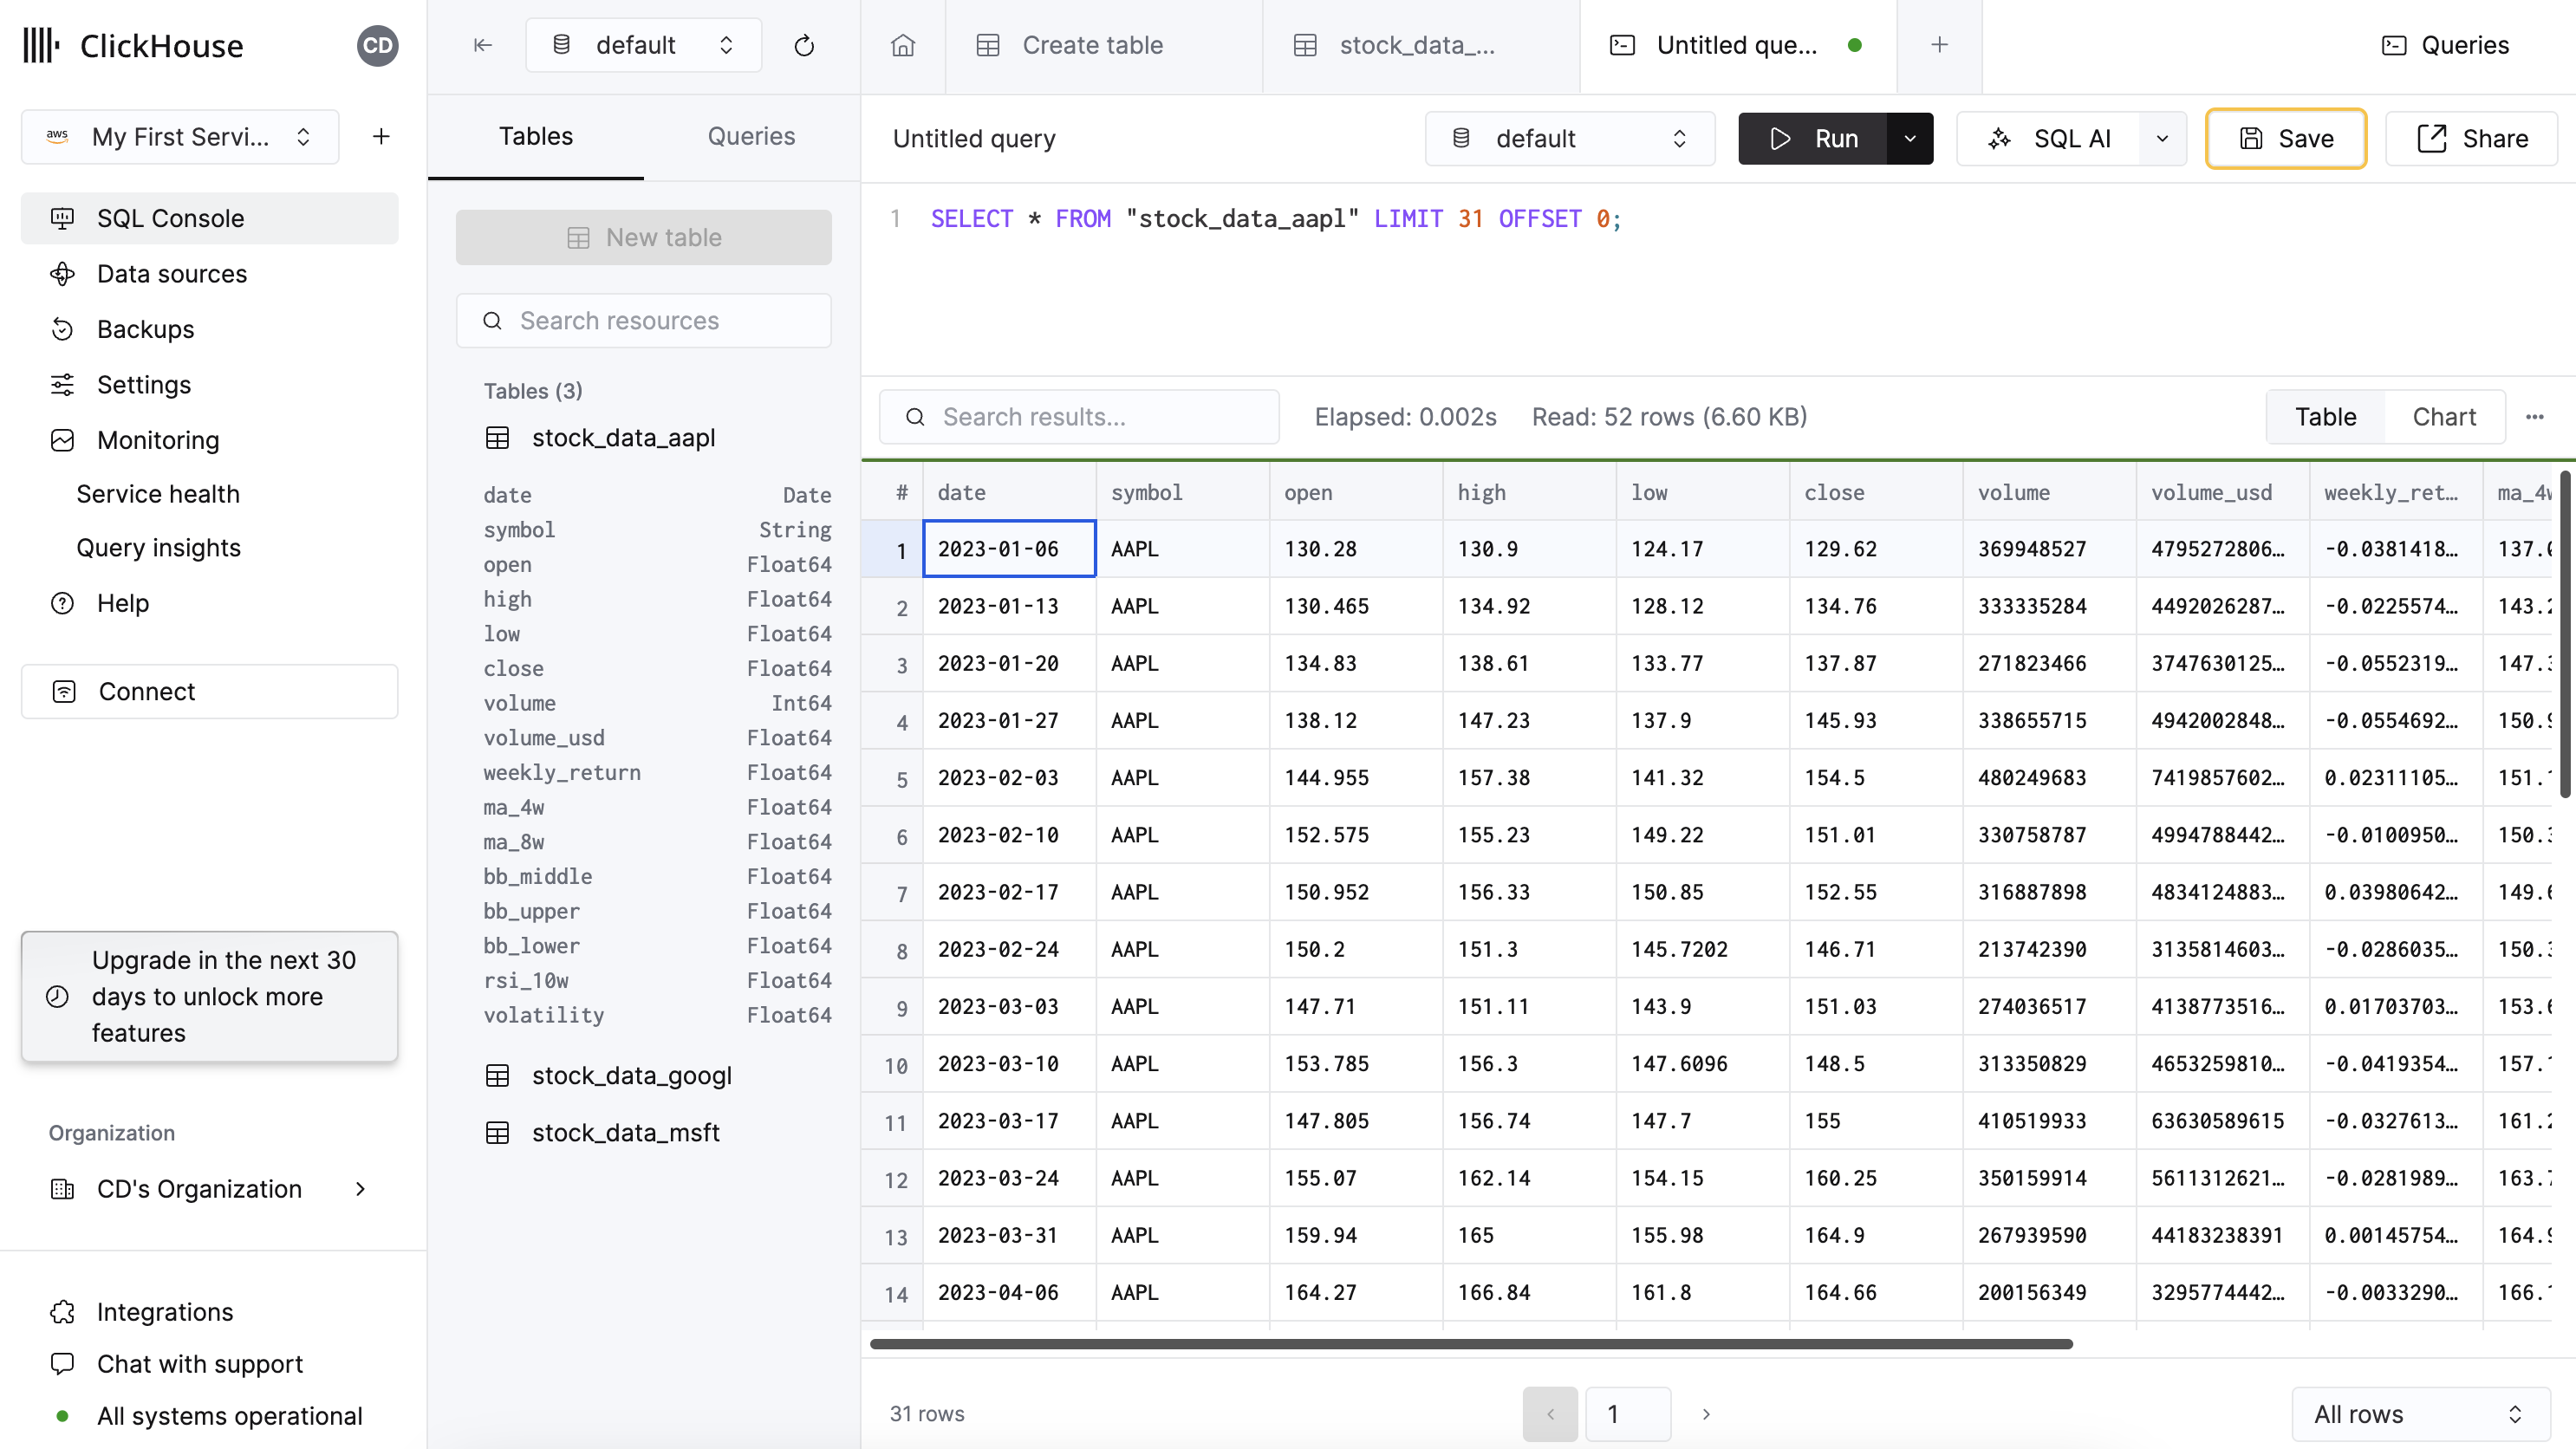

### Step 3 - **Visualisation and Analysis**

Now we will use the [Vega-Altair](https://altair-viz.github.io/index.html) python package to easily make some useful charts to get some insights from the data we extracted. This is the whole point of the exercise, to get some useful information that we can use.


#### Step 3a - **Set up Vega-Altair package for graphing**

In [30]:
!pip install altair vega_datasets

import altair as alt
import pandas as pd
import numpy as np

# Enable Altair to render in Colab
alt.renderers.enable('colab')

# If you want to save charts as PNG (optional)
!pip install altair_saver
!npm install -g vega-lite vega-cli canvas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 844.5/844.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
npm WARN EBADENGINE Unsupported engine {
npm WARN EBADENGINE   package: 'vega-lite@5.21.0',
npm WARN EBADENGINE   required: { node: '>=18' },
npm WARN EBADENGINE   current: { node: 'v16.20.2', npm: '8.19.4' }
npm WARN EBADENGINE }
npm WARN deprecated glob@7.2.3: Glob versions prior to v9 are no longer supported
npm WARN deprecated are-we-there-yet@2.0.0: This package is no longer supported.
npm WARN deprecated rimraf@3.0.2: Rimraf versions prior to v4 are no longer supported
npm WARN deprecated inflight@1.0.6: This module is not supported, and leaks memory. Do not use it. Check out lru-cache if you

#### Step 3b - **Interactive Multi-Stock Price Comparison**

Let's take a look at the trends of the prices of the stocks over the course of 2023, and see what we can learn that way.

In [34]:
# Combine data from all stocks into a single DataFrame
combined_df = pd.concat([
    df.reset_index().rename(columns={'index': 'date'}).assign(symbol=symbol)
    for symbol, df in stock_data.items()
])

# Ensure the date column is properly formatted
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Create the chart
chart = alt.Chart(combined_df).mark_line().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('close:Q', title='Closing Price'),
    color='symbol:N',
    tooltip=['symbol', 'date', 'close']
).properties(
    width=800,
    height=400,
    title='Stock Price Comparison'
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

I like Vega-Altair here as it lets you create interactive visualisations. You can zoom in and out on the chart above to look more closely at different periods in the year. There are lots of solid python data visualisation options we could have used here, from trusty classic Matplotlib to Seaborn, Pygal and more.

In terms of insights we can draw here, my first observations are as follows.

1. MSFT has shown the strongest price appreciation over the year, followed by AAPL, then GOOGL.
2. All three stocks show an upward trend, with MSFT experiencing a significant price increase in the latter half of the year.
3. GOOGL's price movement has been relatively flat compared to the others.

#### Step 3b - **Stock Volatility Comparison**

Let's plot the volatility of each stock over the period, and see what we can learn that way.

In [35]:
# Combine data from all stocks into a single DataFrame
combined_df = pd.concat([
    df.reset_index().rename(columns={'index': 'date'}).assign(symbol=symbol)
    for symbol, df in stock_data.items()
])

# Ensure the date column is properly formatted
combined_df['date'] = pd.to_datetime(combined_df['date'])

chart = alt.Chart(combined_df).mark_line().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('volatility:Q', title='Volatility'),
    color='symbol:N',
    tooltip=['symbol', 'date', 'volatility']
).properties(
    width=800,
    height=400,
    title='Stock Volatility Comparison'
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

1. GOOGL consistently shows higher volatility than AAPL and MSFT.
2. AAPL generally has the lowest volatility among the three.
3. All stocks show spikes in volatility at various points, possibly corresponding to earnings reports or major market events.

Insight: Google's higher volatility suggests it might be more sensitive to market news or internal factors. Apple's lower volatility could make it attractive to risk-averse investors.

#### Step 3c - **Volume Analysis**

We can also plot the stock prices compared to the trading volumes, to see which stocks are most liquid and often-traded.

In [36]:
# Combine data from all stocks into a single DataFrame
combined_df = pd.concat([
    df.reset_index().rename(columns={'index': 'date'}).assign(symbol=symbol)
    for symbol, df in stock_data.items()
])

# Ensure the date column is properly formatted
combined_df['date'] = pd.to_datetime(combined_df['date'])

base = alt.Chart(combined_df).encode(x='date:T')

volume_chart = base.mark_bar(opacity=0.5).encode(
    y=alt.Y('volume:Q', title='Trading Volume'),
    color='symbol:N'
)

price_chart = base.mark_line().encode(
    y=alt.Y('close:Q', title='Closing Price'),
    color='symbol:N'
)

chart = alt.layer(volume_chart, price_chart).resolve_scale(
    y='independent'
).properties(
    width=800,
    height=400,
    title='Stock Price and Trading Volume'
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)




1. Trading volumes for all three stocks show periodic spikes, likely corresponding to earnings releases or significant news events.
2. AAPL consistently has the highest trading volume, indicating high liquidity and investor interest.
3. There's no clear correlation between trading volume and price movements across all stocks.

Insight: Apple's high trading volume suggests it's a highly liquid stock, which can be attractive for large institutional investors. The periodic volume spikes across all stocks highlight the importance of staying informed about company announcements and earnings reports.

#### Step 3d - **Technical Analysis**

Let's look only at AAPL here. Of course we can repeat this for each stock if we wish to.

In [37]:
# Assuming we're using AAPL data for this example
df = stock_data['AAPL'].reset_index().rename(columns={'index': 'date'})
df['date'] = pd.to_datetime(df['date'])

base = alt.Chart(df).encode(x='date:T')

price_chart = base.mark_line(color='blue').encode(
    y=alt.Y('close:Q', title='Price')
)

ma_4w = base.mark_line(color='red').encode(
    y='ma_4w:Q'
)

ma_8w = base.mark_line(color='green').encode(
    y='ma_8w:Q'
)

bb_upper = base.mark_line(color='gray', strokeDash=[5,5]).encode(
    y='bb_upper:Q'
)

bb_lower = base.mark_line(color='gray', strokeDash=[5,5]).encode(
    y='bb_lower:Q'
)

chart = (price_chart + ma_4w + ma_8w + bb_upper + bb_lower).properties(
    width=800,
    height=400,
    title='AAPL Technical Analysis'
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

1. The stock price has generally stayed within the Bollinger Bands, with occasional breakouts.
2. The 4-week moving average (the red line) responds more quickly to price changes than the 8-week moving average (green line).
3. There are several instances where the price crosses these moving averages, which could be used as trading signals.

Insight: Apple's stock has shown relatively stable growth with some volatility. The technical indicators suggest there have been both buying and selling opportunities throughout the year. Investors using technical analysis might look for crossovers of the moving averages or touches of the Bollinger Bands as potential entry or exit points.

#### Step 3d - **Correlation Heatmap**

Let's see how closely correlated these stocks are. They are all US-based tech stocks, so not the most diversified set we could have. Let's see what the numbers show.

In [38]:
# Combine weekly returns for all stocks
returns_df = pd.DataFrame({symbol: df['weekly_return'] for symbol, df in stock_data.items()})

# Calculate correlation matrix
corr_matrix = returns_df.corr()

# Melt the correlation matrix for use with Altair
melted_corr = corr_matrix.reset_index().melt('index', var_name='variable', value_name='correlation')

# Create heatmap
heatmap = alt.Chart(melted_corr).mark_rect().encode(
    x='index:O',
    y='variable:O',
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='blueorange'))
)

# Add text labels
text = heatmap.mark_text().encode(
    text=alt.Text('correlation:Q', format='.2f'),
    color=alt.condition(
        alt.datum.correlation > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine heatmap and text layers
chart = (heatmap + text).properties(
    width=400,
    height=300,
    title='Correlation of Weekly Returns'
).interactive()

chart

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)




1. All three stocks show positive correlations, indicating they generally move in the same direction.
2. AAPL and MSFT have the highest correlation (0.58), suggesting they react similarly to market conditions.
3. GOOGL has a lower correlation with both AAPL (0.48) and MSFT (0.47), indicating it may offer some diversification benefits.

Insight: While these tech stocks are positively correlated, there's still room for diversification. An investor might consider including GOOGL alongside AAPL or MSFT to reduce portfolio risk.

### Analysis - Summary

1. Diversification: While these tech giants are correlated, including all three could still offer some diversification benefits, especially with Google's lower correlation to the others.
2. Performance Divergence: Microsoft's strong performance suggests it might be capitalizing on market trends (like AI and cloud computing) more effectively than its peers. Investors might want to research the drivers behind this outperformance.
3. Risk Assessment: Google's higher volatility might offer greater potential returns but with increased risk. Apple's lower volatility could make it suitable for more conservative investors.
4. Market Reactions: The volume spikes and volatility changes highlight the importance of earnings reports and major announcements in these stocks' performance.
5. Technical Trading: For active traders, these stocks (especially Apple, as shown) offer various technical trading opportunities based on moving averages and Bollinger Bands.
6. Liquidity: All three stocks, particularly Apple, show high trading volumes, making them suitable for large investments without significantly impacting the market price.
7. Sector Trends: The overall upward trend across all three stocks suggests a positive outlook for the tech sector, possibly driven by advancements in AI, cloud computing, and digital services.

These insights can help inform investment decisions, but it's crucial to combine this technical analysis with fundamental analysis and broader market research for a comprehensive investment strategy.

# Conclusion

We have used python to perform a full ETL pipeline, extracting stock market data from the Alpha Vantage API, transforming it, loading it into Clickhouse's cloud database solution, and then performing analysis on it using powerful visualisation tools to identify insights from the data.

We used historical data here, but it is clear how the same techniques could be applied to current data, providing insights to guide an investment strategy.

The transform step of this pipeline was deliberately kept relatively simple, to keep things clearer. In a real-life pipeline we might be using data extracted from multiple sources and joining together to enrich it further and find more relevant and specialised insights. In my daily work this is the kind of thing we do all the time.

Hopefully this showed how we can relatively easily set up an ETL pipeline using publicly-available data to derive actionable insights.

Let me know what you think, I'd love to hear your feedback. Drop me a line [here](https://www.craigdoesdata.com/contact). Thanks!